# Artificial Neural Networks and Deep Learning - Assignment 2



## 📃 Task



In this assignment, you will receive 64x128 grayscale real images from Mars terrain. Pixels in these images are categorized into five classes, each representing a particular type of terrain. This is a semantic segmentation problem, so your goal is to assign the correct class label to each mask pixel.

In [39]:
is_kaggle = True
is_colab = False
manual_analysis = False  # DO NOT CHANGE TO THIS IF YOU DO NOT WANT TO FILL YOUR DRIVE WITH IMAGES

In [40]:
# Name of the model using the date
from datetime import datetime

timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"big_rock_model"
print(model_filename)

big_rock_model


## 🌐 Connect Colab to Google Drive

In [41]:
if is_colab:
    from google.colab import drive

    drive.mount("/gdrive")
    %cd /gdrive/My Drive/Colab Notebooks/[2024-2025] AN2DL/Homework 2

## ⚙️ Import Libraries

In [42]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt
%matplotlib inline

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 2


In [43]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

colors = ['#440154', '#3b528b', '#21918c', '#5ec962', '#fde725']
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(np.arange(6), cmap.N)

class_names = ["Background", "Soil", "Bedrock", "Sand", "Big Rock"]

## ⏳ Load the Data

In [44]:
if is_colab:
    data = np.load("mars_for_students.npz")
elif is_kaggle:
    data = np.load("/kaggle/input/mars-rocks-dataset/mars_for_students.npz")  # change this with the actual kaggle path
else:
    data = np.load("../mars_for_students.npz")

training_set = data["training_set"] # ['training_set', 'test_set']
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


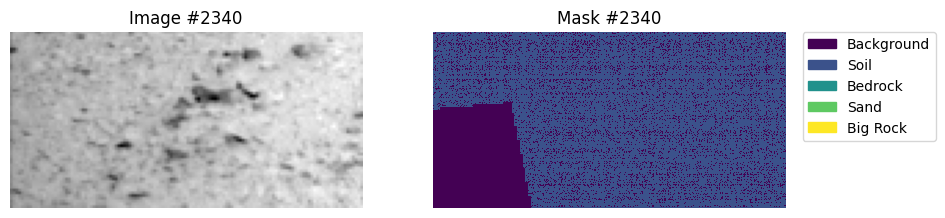

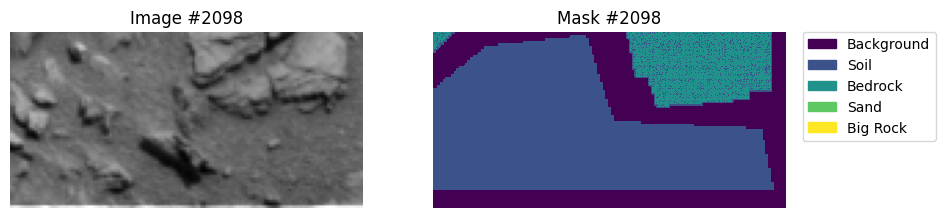

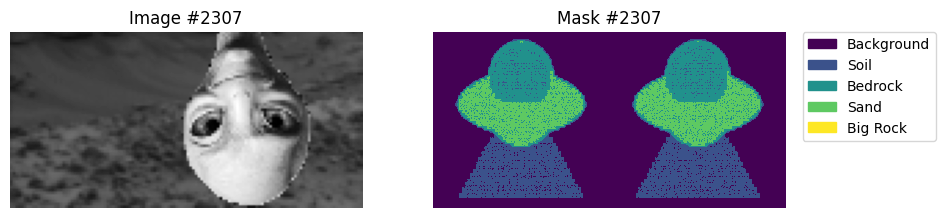

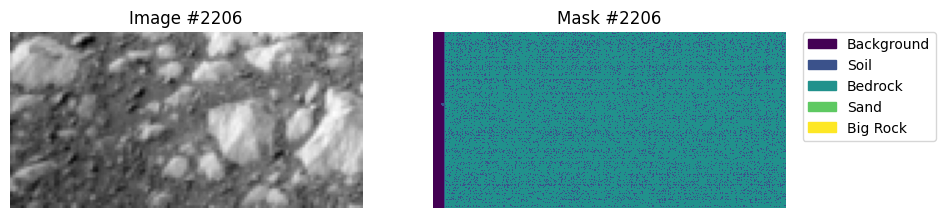

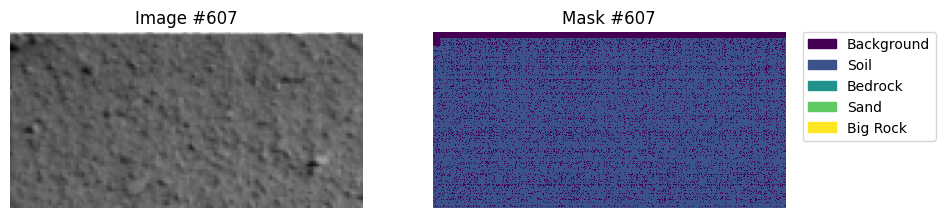

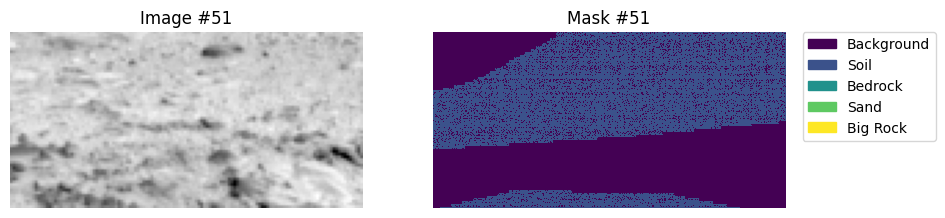

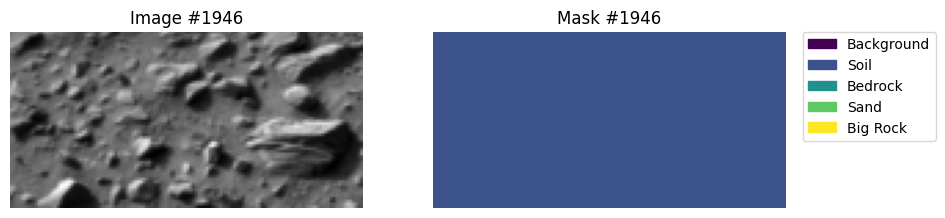

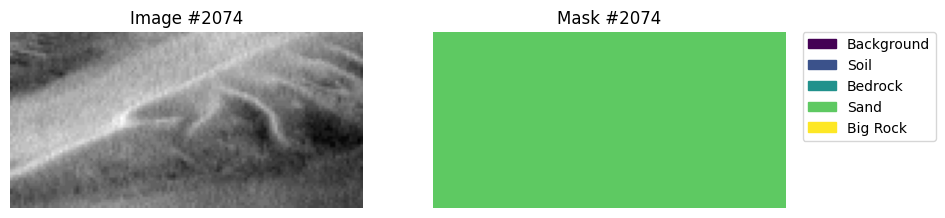

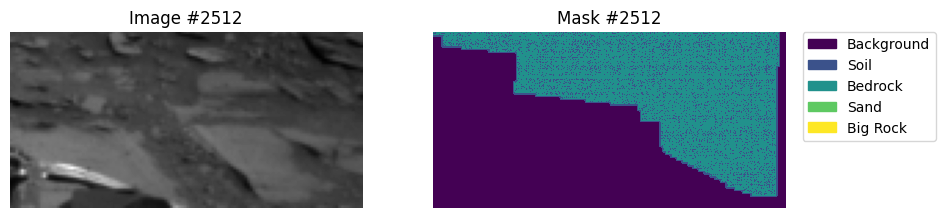

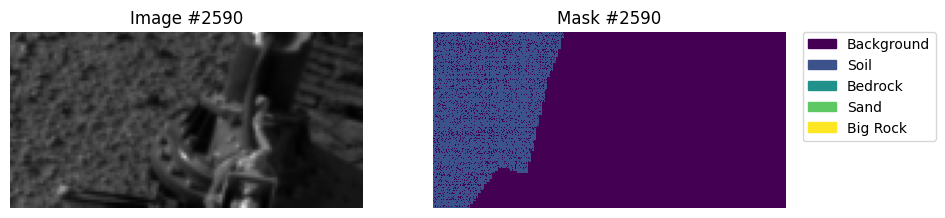

In [45]:
import random
import matplotlib.patches as mpatches

index = random.randint(0, X_train.shape[0])

# Visualize images and masks
def visualize_sample(image, mask, index):
    plt.figure(figsize=(10, 5))

    # image
    plt.subplot(1, 2, 1)
    plt.title(f"Image #{index}")
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    # mask
    plt.subplot(1, 2, 2)
    plt.title(f"Mask #{index}")
    plt.imshow(mask, cmap=cmap, norm=norm)
    plt.axis('off')

    # Create custom legend
    colors = cmap.colors
    patches = [mpatches.Patch(color=colors[i], label=class_names[i]) for i in range(5)]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.show()

# Visualize an example from the dataset
indd = np.zeros(10, dtype=int)
for i in range(10):
    indd[i] = random.randint(0, X_train.shape[0])
    visualize_sample(X_train[indd[i]], y_train[indd[i]], index=indd[i])

### 🧹 Data cleaning

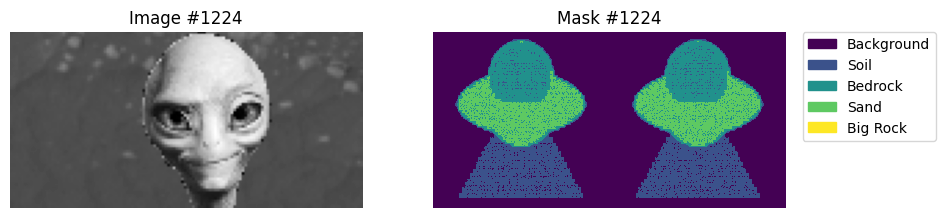

In [46]:
# Visualize an example from the dataset
index = 1224
visualize_sample(X_train[index], y_train[index], index=index)

In [47]:
import numpy as np
import matplotlib.pyplot as plt

"""
Remove samples from the dataset where the mask matches the alien_mask.

Args:
    X (numpy array): Array of images (shape: [n_samples, height, width]).
    Y (numpy array): Array of masks (shape: [n_samples, height, width]).
    alien_mask (numpy array): The mask to identify alien samples.

Returns:
    X_cleaned, Y_cleaned: Cleaned arrays without alien samples.
"""

def remove_alien_samples(X, Y, alien_mask):
    # Find indices where masks do NOT match the alien mask
    indices_to_keep = [i for i in range(Y.shape[0]) if not np.array_equal(Y[i], alien_mask)]

    # Filter the dataset to keep only valid samples
    X_cleaned = X[indices_to_keep]
    Y_cleaned = Y[indices_to_keep]

    return X_cleaned, Y_cleaned

# Load the alien mask image (the first one is the number 62 of the dataset)
alien_mask = y_train[62]

# remove alien samples from the dataset
X_train_cleaned, y_train_cleaned = remove_alien_samples(X_train, y_train, alien_mask)

# print the shapes of the original and cleaned datasets
print(f"Original shape: {X_train.shape}, {y_train.shape}")
print(f"Cleaned shape: {X_train_cleaned.shape}, {y_train_cleaned.shape}")

# Update the training set with the cleaned data
X_train = X_train_cleaned
y_train = y_train_cleaned

Original shape: (2615, 64, 128), (2615, 64, 128)
Cleaned shape: (2505, 64, 128), (2505, 64, 128)



### 🔍 Inspect the Dataset

In [48]:
# save valuable information about the dataset
dataset_info = {
    "training_set_shape": X_train.shape,
    "test_set_shape": X_test.shape,
    "image_dimensions": X_train.shape[1:],
    "mask_dimensions": y_train.shape[1:],
    "number_of_classes": len(np.unique(y_train)),
    "segmentation_classes": np.unique(y_train),
}
# Display information about the dataset
print(f"Dataset keys: {data.files}")
print(f"Training set: {dataset_info['training_set_shape']}")
print(f"Test set: {dataset_info['test_set_shape']}")
print(f"Image dimensions (train): {dataset_info['image_dimensions']}")
print(f"Mask dimensions (train): {dataset_info['mask_dimensions']}")
print(f"Number of classes: {dataset_info['number_of_classes']}")
print(f"Segmentation classes: {dataset_info['segmentation_classes']}")

Dataset keys: ['training_set', 'test_set']
Training set: (2505, 64, 128)
Test set: (10022, 64, 128)
Image dimensions (train): (64, 128)
Mask dimensions (train): (64, 128)
Number of classes: 5
Segmentation classes: [0. 1. 2. 3. 4.]


Class distribution:
Class 0 (Background): 4988826 pixels (24.31%)
Class 1 (Soil): 6957538 pixels (33.90%)
Class 2 (Bedrock): 4776810 pixels (23.28%)
Class 3 (Sand): 3770823 pixels (18.38%)
Class 4 (Big Rock): 26963 pixels (0.13%)


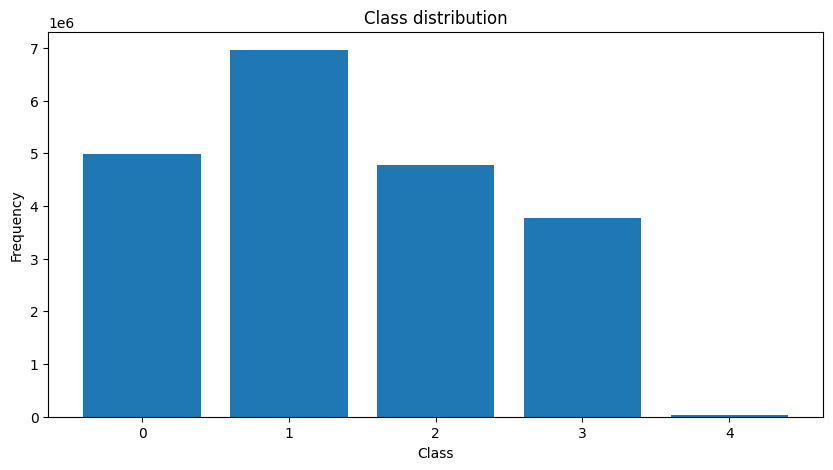

In [49]:
# Visualize the distribution of classes in the dataset
def display_class_distribution(y_train=y_train):
    unique, counts = np.unique(y_train, return_counts=True)
    class_distribution = dict(zip(unique, counts))

    print("Class distribution:")

    for class_label, count in class_distribution.items():
        print(f"Class {int(class_label)} ({class_names[int(class_label)]}): {count} pixels ({count / np.sum(counts) * 100:.2f}%)")

    # Visualize the class distribution
    plt.figure(figsize=(10, 5))
    plt.bar(class_distribution.keys(), class_distribution.values())
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.title("Class distribution")
    plt.show()

display_class_distribution()

## 🧹 Data Preprocessing

### 📂 Data Splitting

In [50]:
# # Split the training set into training and validation sets (80% training, 20% validation)
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

# Display the shapes of the training and validation sets
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")

Training set: (2004, 64, 128), (2004, 64, 128)
Validation set: (501, 64, 128), (501, 64, 128)


### 📊 Data Normalization

In [51]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_val = X_val[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

# print shape
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Training set: (2004, 64, 128, 1)
Validation set: (501, 64, 128, 1)
Test set: (10022, 64, 128, 1)


### 📚 Data Augmentation

In [52]:
!pip install -q keras_cv

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [53]:
print("Image shape:", X_train.shape[1:])
print("Mask shape:", y_train.shape[1:])

Image shape: (64, 128, 1)
Mask shape: (64, 128)


In [54]:
import keras_cv

# Augmentation pipeline for images and masks
# This augmentation will include transformations that do not change the class of the pixel on the mask
def create_segmentation_augmentation_pipeline(segmentation_classes=dataset_info['number_of_classes'], seed=seed):
    # Define augmentation layers for segmentation

    layers = [
        # Geometric transformations
        keras_cv.layers.RandomFlip(mode='horizontal_and_vertical', seed=seed),
        keras_cv.layers.RandomTranslation(
            height_factor=(-0.5, 0.5),  # Limited shift
            width_factor=(-0.5, 0.5),
            seed=seed,
            fill_mode='nearest'
        ),

        keras_cv.layers.RandomRotation(
            factor=(-0.1, 0.1),  # Slight rotations
            seed=seed,
            fill_mode='nearest',
            segmentation_classes=segmentation_classes
        ),

        keras_cv.layers.RandomCrop(
            height = dataset_info['image_dimensions'][0],
            width = dataset_info['image_dimensions'][1],
            seed=seed,
        ),

        keras_cv.layers.RandomZoom(
            height_factor=(-0.5, 0.5),  # Limited zoom
            width_factor=(-0.5, 0.5),
            seed=seed,
            fill_mode='nearest',
        )
    ]

    # Create the pipeline with moderate application rate
    pipeline = keras_cv.layers.RandomAugmentationPipeline(
        layers=layers,
        augmentations_per_image=2,  # Apply 2 random augmentations per image
        rate=1,  # 100% chance of applying augmentation to each image
        seed=seed
    )

    return pipeline

image_mask_augmentation_pipeline = create_segmentation_augmentation_pipeline(seed = seed)

In [55]:
def augment_segmentation_data(images, masks, pipeline, segmentation_classes, epoch):
    if epoch % 2 == 0:
        # Concatenate image and mask
        images = tf.cast(images, tf.float32)    # Ensure images are float32
        mask = tf.cast(masks, tf.float32)       # Ensure mask is float32
        combined = tf.concat([images, tf.expand_dims(mask, axis=-1)], axis=-1)

        # Apply augmentation
        augmented = pipeline(combined)

        # Separate augmented images and masks
        augmented_images = augmented[..., :images.shape[-1]]
        augmented_masks = tf.cast(tf.squeeze(augmented[..., images.shape[-1]:], axis=-1), tf.int32) # Ensure mask is int32 again

        return augmented_images, augmented_masks
    else:
        return images, masks

In [56]:
def visualize_segmentation_augmentations(images, masks, pipeline, epoch, segmentation_classes=dataset_info['number_of_classes'], num_samples=2):
    # Generate random indices
    random_indices = np.random.choice(len(images), size=num_samples, replace=False)

    # Get original images and masks
    original_images = images[random_indices]
    original_masks = masks[random_indices]

    # Prepare figures
    fig, axes = plt.subplots(2, 2*num_samples)
    fig.set_figheight(6)
    fig.set_figwidth(12)

    # Augment samples
    for i, (image, mask) in enumerate(zip(original_images, original_masks)):
        # Apply augmentation
        augmented_image, augmented_mask = augment_segmentation_data(
            tf.expand_dims(image, 0),
            tf.expand_dims(mask, 0),
            pipeline=pipeline,
            segmentation_classes=segmentation_classes,
            epoch = 0
        )

        # Squeeze dimensions
        augmented_image = augmented_image.numpy().squeeze()
        augmented_mask = augmented_mask.numpy().squeeze()

        # Ensure the images and masks have the correct shape
        if len(image.shape) == 2:
            image = image[..., np.newaxis]

        if len(mask.shape) == 2:
            mask = mask[..., np.newaxis]

        if len(augmented_image.shape) == 2:
            augmented_image = augmented_image[..., np.newaxis]

        if len(augmented_mask.shape) == 2:
            augmented_mask = augmented_mask[..., np.newaxis]

        # Plot original image
        axes[0, 2*i].imshow(image[..., 0], cmap='gray')
        axes[0, 2*i].set_title(f'Original Image {random_indices[i]}')
        axes[0, 2*i].axis('off')

        # Plot original mask
        axes[0, 2*i+1].imshow(mask[..., 0], cmap='viridis')
        axes[0, 2*i+1].set_title(f'Original Mask {random_indices[i]}')
        axes[0, 2*i+1].axis('off')

        # Plot augmented image
        axes[1, 2*i].imshow(augmented_image[..., 0], cmap='gray')
        axes[1, 2*i].set_title(f'Augmented Image {random_indices[i]}')
        axes[1, 2*i].axis('off')

        # Plot augmented mask
        axes[1, 2*i+1].imshow(augmented_mask[..., 0], cmap='viridis')
        axes[1, 2*i+1].set_title(f'Augmented Mask {random_indices[i]}')
        axes[1, 2*i+1].axis('off')

        # display image information (shape, min, max, dtype)
        print(f"Image {random_indices[i]} - Original: {image.shape}, {image.min()}, {image.max()}, {image.dtype}")
        print(f"Image {random_indices[i]} - Augmented: {augmented_image.shape}, {augmented_image.min()}, {augmented_image.max()}, {augmented_image.dtype}")

    # Create custom legend
    colors = [plt.cm.viridis(i / 4) for i in range(5)]
    patches = [mpatches.Patch(color=colors[i], label=class_names[i]) for i in range(5)]
    fig.legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=5)

    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.tight_layout(h_pad=0.5, w_pad=0.5)
    plt.show()


### ⚖️ Data Balancing

In [57]:
def remove_single_class_samples(X_train, y_train):
  total_removed = 0

  for i in range(dataset_info["number_of_classes"]):
      mask_indeces_with_single_class = [j for j in range(y_train.shape[0]) if np.all(y_train[j] == i)]

      print(f"Class {i} ({class_names[i]}): {len(mask_indeces_with_single_class)} samples")

      total_removed += len(mask_indeces_with_single_class)

      # remove samples with only one class
      if len(mask_indeces_with_single_class) > 0:
          X_train = np.delete(X_train, mask_indeces_with_single_class, axis=0)
          y_train = np.delete(y_train, mask_indeces_with_single_class, axis=0)

  # Display the shapes of the training and validation sets
  print(f"Training set: {X_train.shape}, {y_train.shape}")
  print(f"Removed samples: {total_removed}")

  return X_train, y_train

X_train, y_train = remove_single_class_samples(X_train, y_train)

Class 0 (Background): 4 samples
Class 1 (Soil): 182 samples
Class 2 (Bedrock): 70 samples
Class 3 (Sand): 73 samples
Class 4 (Big Rock): 0 samples
Training set: (1675, 64, 128, 1), (1675, 64, 128)
Removed samples: 329


Class distribution:
Class 0 (Background): 3947125 pixels (28.77%)
Class 1 (Soil): 4041218 pixels (29.45%)
Class 2 (Bedrock): 3351153 pixels (24.42%)
Class 3 (Sand): 2360775 pixels (17.20%)
Class 4 (Big Rock): 21329 pixels (0.16%)


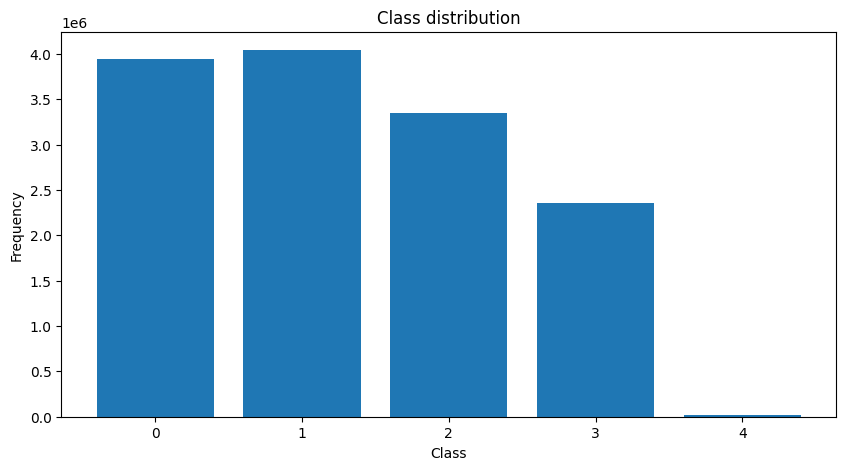

In [58]:
# Visualize the distribution of classes in the training set
display_class_distribution(y_train)

In [59]:
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))
print(class_distribution) # number of pixels for each class
print(sum(class_distribution.values())) # total number of pixels

{0.0: 3947125, 1.0: 4041218, 2.0: 3351153, 3.0: 2360775, 4.0: 21329}
13721600


In [60]:
#@title balancing function
import numpy as np
import cv2

def balance_classes(X_train, y_train, class_distribution_train, k):
  # class_distribution_train is a dictionary that maps each class to the number of examples
  # that are actually present for that class
    """
    Balance dataset by finding and cropping regions of specific classes
    """
    # Find target class distribution (mean of all classes)
    mean_count = np.mean(list(class_distribution_train.values())) # obtain a mean among all the 5 classes
    max_count = max(class_distribution_train.values())

    # Ensure X_train and y_train have consistent shapes
    if X_train.ndim == 3:
        X_train = X_train[..., np.newaxis]
    if y_train.ndim == 3:
        y_train = y_train[..., np.newaxis]

    # Lists to store new samples to balance the dataset
    new_X_train = []
    new_y_train = []

    total_added = 0 # keep track of the number of new samples

    for classe, current_count in class_distribution_train.items():
        if classe == 0:  # Skip background
            continue

        # Determine multiplier to balance class
        if classe == k: # consider a class that is defined in the input
            multiplier = int(mean_count) // (current_count)
        else:
            multiplier = int(mean_count) // (7 * current_count)
        print(f"Multiplier for class {classe}: {int(mean_count)} // {current_count} = {multiplier}")

        # Find images containing the current class
        class_indices = [i for i in range(len(y_train))
                         if classe in np.unique(y_train[i, :, :, 0])]
                         # this list contains all the indices that correspond to the training masks
                         # putting together all the ones that contain that class

        class_added = 0

        for idx in class_indices:
            # Find bounding box for the specific class
            mask = y_train[idx, :, :, 0]
            class_mask = (mask == classe).astype(np.uint8)

            # Find contours of the class region
            contours, _ = cv2.findContours(class_mask,
                                           cv2.RETR_EXTERNAL,
                                           cv2.CHAIN_APPROX_SIMPLE)

            if not contours:
                continue

            # Get bounding rectangle of the class
            x, y, w, h = cv2.boundingRect(contours[0])

            # Extend bounding box with some margin
            margin = max(w, h) // 4
            x = max(0, x - margin)
            y = max(0, y - margin)
            w = min(X_train[idx].shape[1] - x, w + 2 * margin)
            h = min(X_train[idx].shape[0] - y, h + 2 * margin)

            # Crop image and mask
            cropped_img = X_train[idx][y:y + h, x:x + w, :]
            cropped_mask = y_train[idx][y:y + h, x:x + w, :]

            # Resize to (64, 128)
            resized_img = cv2.resize(cropped_img, (128, 64),
                                     interpolation=cv2.INTER_AREA)
            resized_mask = cv2.resize(cropped_mask, (128, 64),
                                      interpolation=cv2.INTER_NEAREST)

            # Duplicate samples to balance class
            for _ in range(multiplier):
                new_X_train.append(resized_img)
                new_y_train.append(resized_mask)
                class_added += 1

        print(f"Added {class_added} elements for class {classe}")
        total_added += class_added

    print(f"Total elements added: {total_added}")

    # Convert to numpy arrays with consistent shapes
    new_X_train = np.array(new_X_train)
    new_y_train = np.array(new_y_train)

    return new_X_train, new_y_train


Multiplier for class 1.0: 2744320 // 4041218 = 0
Added 0 elements for class 1.0
Multiplier for class 2.0: 2744320 // 3351153 = 0
Added 0 elements for class 2.0
Multiplier for class 3.0: 2744320 // 2360775 = 1
Added 615 elements for class 3.0
Multiplier for class 4.0: 2744320 // 21329 = 18
Added 1008 elements for class 4.0
Total elements added: 1623
Balanced training set: (1623, 64, 128), (1623, 64, 128)
Class distribution:
Class 0 (Background): 5354153 pixels (40.27%)
Class 1 (Soil): 558775 pixels (4.20%)
Class 2 (Bedrock): 881935 pixels (6.63%)
Class 3 (Sand): 3690726 pixels (27.76%)
Class 4 (Big Rock): 2810027 pixels (21.13%)


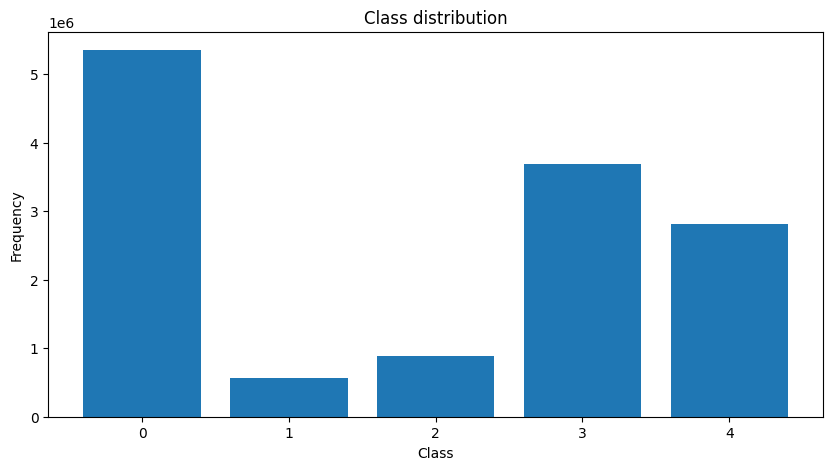

In [61]:
# Balance the dataset
X_train_balanced, y_train_balanced = balance_classes(X_train, y_train, class_distribution, 3)

# Display the shapes of the balanced training set
print(f"Balanced training set: {X_train_balanced.shape}, {y_train_balanced.shape}")

# Display the distribution of classes in the balanced training set
display_class_distribution(y_train_balanced)

In [62]:
X_train_balanced, y_train_balanced = remove_single_class_samples(X_train_balanced, y_train_balanced)

Class 0 (Background): 0 samples
Class 1 (Soil): 0 samples
Class 2 (Bedrock): 0 samples
Class 3 (Sand): 19 samples
Class 4 (Big Rock): 144 samples
Training set: (1460, 64, 128), (1460, 64, 128)
Removed samples: 163


Class distribution:
Class 0 (Background): 5354153 pixels (44.77%)
Class 1 (Soil): 558775 pixels (4.67%)
Class 2 (Bedrock): 881935 pixels (7.37%)
Class 3 (Sand): 3535078 pixels (29.56%)
Class 4 (Big Rock): 1630379 pixels (13.63%)


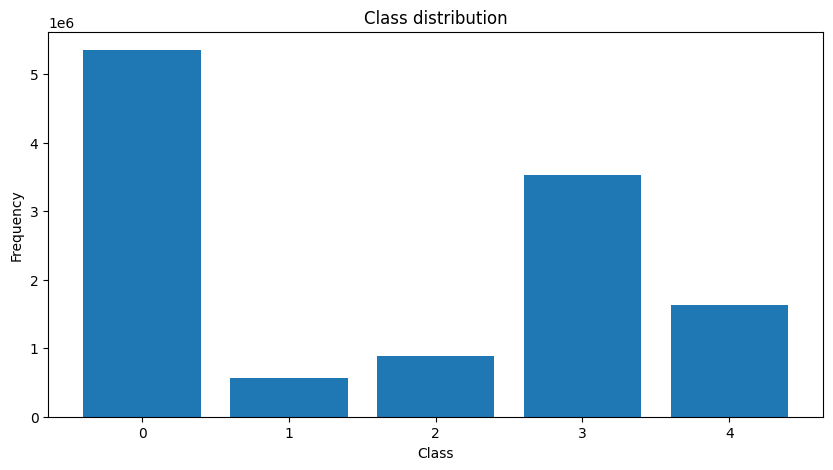

In [63]:
display_class_distribution(y_train_balanced)

[ 507  846  965 1179   73  897 1363 1402 1297  613]


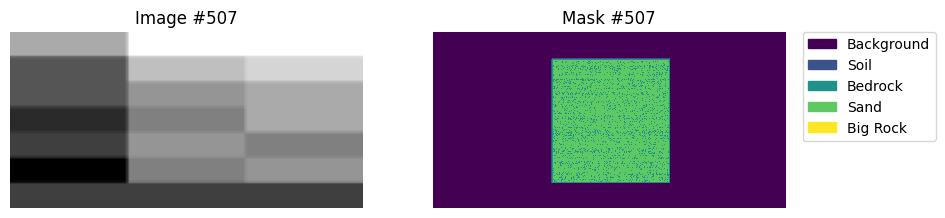

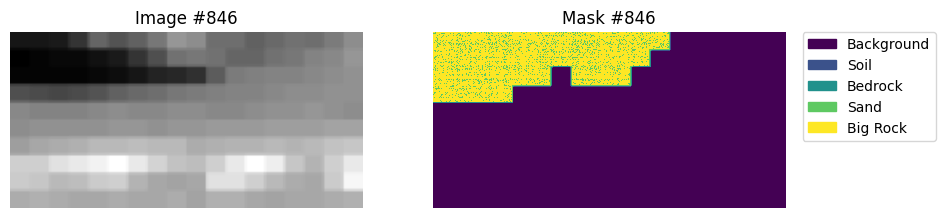

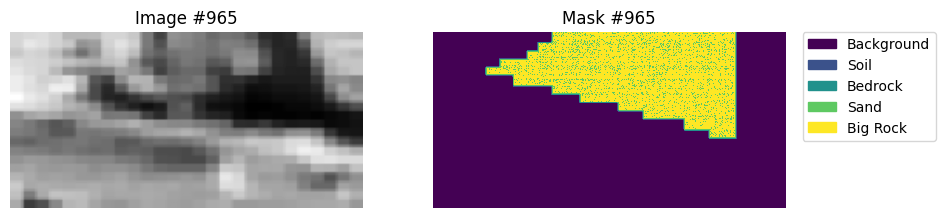

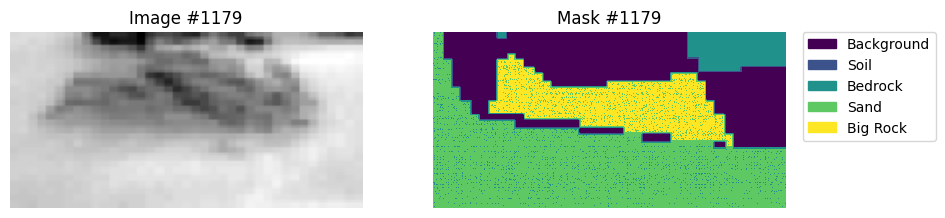

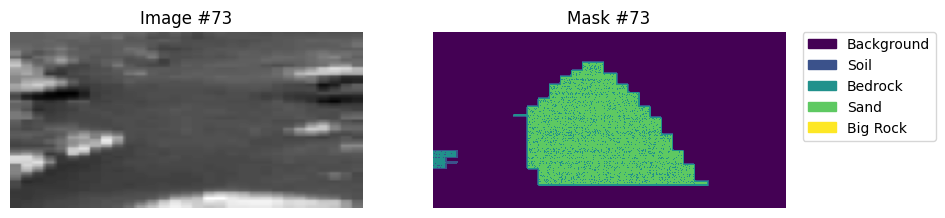

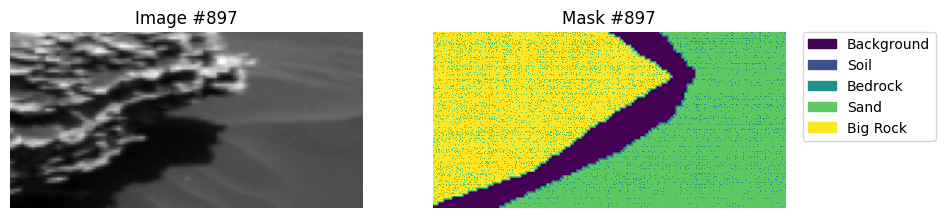

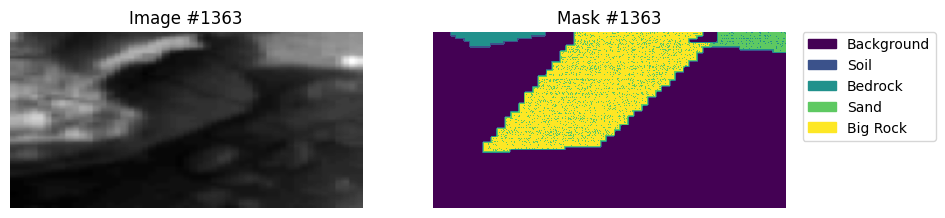

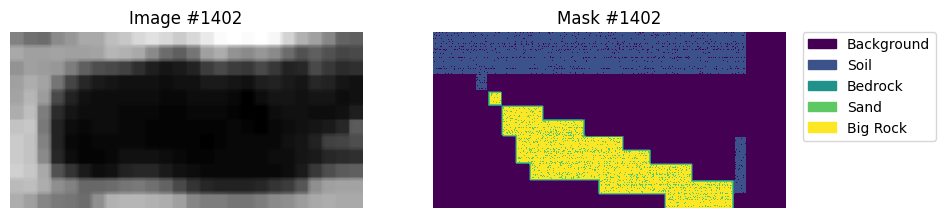

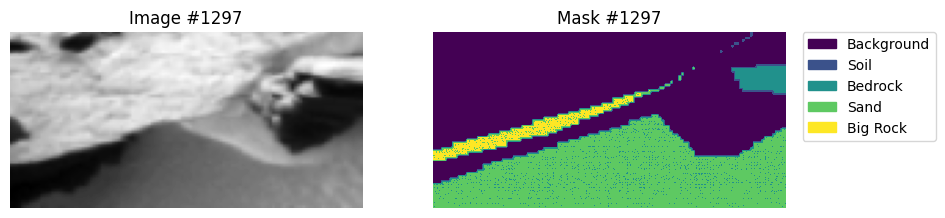

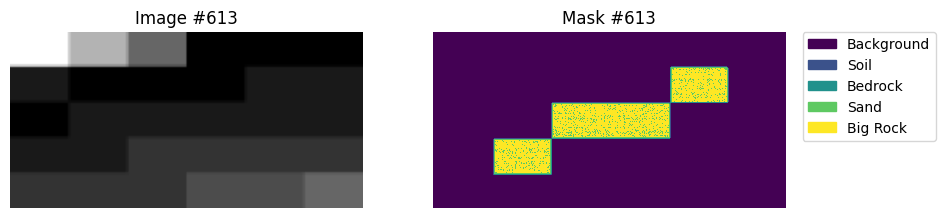

In [64]:
# visualization of these new samples (10 of them at random)
N = 10
indices = np.zeros(N, dtype=int)
for n in range(N):
  indices[n] = random.randint(0, len(X_train_balanced))

print(indices)

for i in indices:
  visualize_sample(X_train_balanced[i], y_train_balanced[i], index=i)

Multiplier for class 1.0: 2744320 // 4041218 = 0
Added 0 elements for class 1.0
Multiplier for class 2.0: 2744320 // 3351153 = 0
Added 0 elements for class 2.0
Multiplier for class 3.0: 2744320 // 2360775 = 1
Added 974 elements for class 3.0
Multiplier for class 4.0: 2744320 // 21329 = 18
Added 16002 elements for class 4.0
Total elements added: 16976
Balanced training set: (16976, 64, 128), (16976, 64, 128)
Class distribution:
Class 0 (Background): 73990002 pixels (53.20%)
Class 1 (Soil): 7015409 pixels (5.04%)
Class 2 (Bedrock): 6003790 pixels (4.32%)
Class 3 (Sand): 20096344 pixels (14.45%)
Class 4 (Big Rock): 31961847 pixels (22.98%)


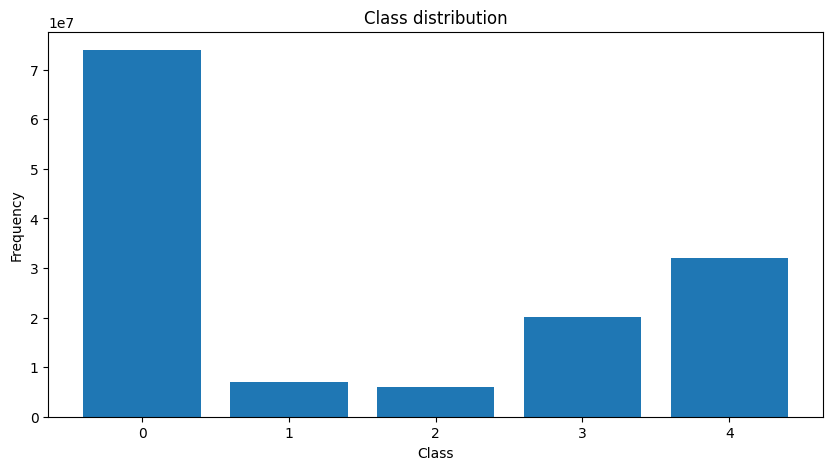

In [65]:
# Balance the dataset
X_train_balanced_bis, y_train_balanced_bis = balance_classes(X_train_balanced, y_train_balanced, class_distribution, 3)

# Display the shapes of the balanced training set
print(f"Balanced training set: {X_train_balanced_bis.shape}, {y_train_balanced_bis.shape}")

# Display the distribution of classes in the balanced training set
display_class_distribution(y_train_balanced_bis)

In [66]:
# I want to select half of the samples to see if the RAM doesn't crash
# background extraction
indices_bg = []

for i in range(y_train_balanced_bis.shape[0]):
    # Calculate the percentage of pixels with value 4
    total_pixels = y_train_balanced_bis[i].size
    pixels_0 = np.sum(y_train_balanced_bis[i] == 0)
    percentage_0 = (pixels_0 / total_pixels) * 100

    # Check if percentage is at least 1%
    if percentage_0 >= 60:
        indices_bg.append(i)
print(len(indices_bg))

8075


In [67]:
# remove these samples
X_train_balanced_bis = np.delete(X_train_balanced_bis, indices_bg, axis=0)
y_train_balanced_bis = np.delete(y_train_balanced_bis, indices_bg, axis=0)

# Display the shapes of the training and validation sets
print(f"Training set: {X_train_balanced_bis.shape}, {y_train_balanced_bis.shape}")

Training set: (8901, 64, 128), (8901, 64, 128)


Class distribution:
Class 0 (Background): 25750349 pixels (35.31%)
Class 1 (Soil): 5765810 pixels (7.91%)
Class 2 (Bedrock): 4148487 pixels (5.69%)
Class 3 (Sand): 19176422 pixels (26.30%)
Class 4 (Big Rock): 18075924 pixels (24.79%)


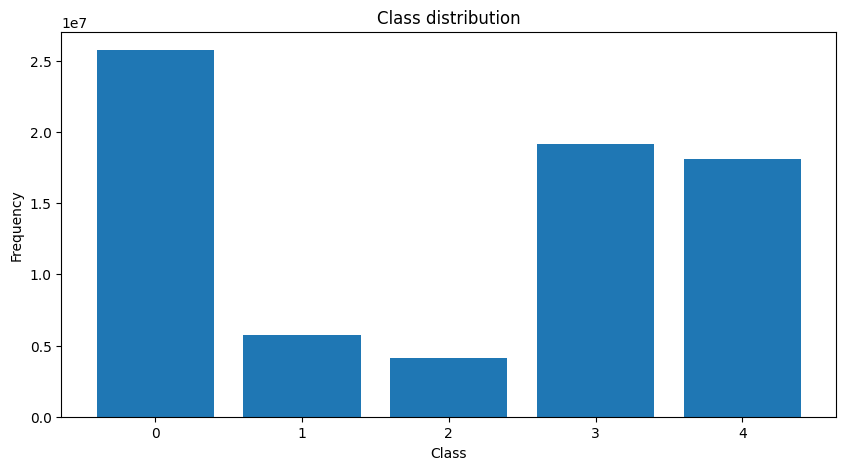

In [68]:
display_class_distribution(y_train_balanced_bis)

In [73]:
 X_train_balanced_bis = X_train_balanced_bis[..., np.newaxis]

In [74]:
X_bis, X_bis_val, y_bis, y_bis_val = train_test_split(X_train_balanced_bis, y_train_balanced_bis, test_size=0.2, random_state=seed)

In [75]:
print(f"Training set: {X_bis.shape}, {y_bis.shape}")
print(f"Validation set: {X_bis_val.shape}, {y_bis_val.shape}")

Training set: (7120, 64, 128, 1), (7120, 64, 128)
Validation set: (1781, 64, 128, 1), (1781, 64, 128)


### 💽 Dataset Creation

In [36]:
# batch size for training
batch_size = 64

In [37]:
#@title DATASETS CREATION
# Convert the data types of the original dataset to match those of the augmented dataset
X_bis = X_bis.astype(np.float32)
y_bis = y_bis.astype(np.int32)
# X_val = X_val.astype(np.float32)
# y_val = y_val.astype(np.int32)

# create an augmentation dataset
train_balanced_dataset = tf.data.Dataset.from_tensor_slices((X_bis, y_bis))
train_balanced_dataset = train_balanced_dataset.shuffle(buffer_size=1024).batch(batch_size)

# apply augmentation to the dataset using the augmentation pipeline
# all the training samples will be augmented
train_balanced_dataset = train_balanced_dataset.map(
    lambda x, y: augment_segmentation_data(
        x, y, image_mask_augmentation_pipeline, dataset_info['number_of_classes'], epoch = 0
    ),
    num_parallel_calls=tf.data.AUTOTUNE
)

# now the training set is the augmented one (the augmentation is applied only on even epochs)
train_dataset = train_balanced_dataset

# Shuffle the training set
train_dataset = train_dataset.shuffle(buffer_size=1024)

# Prefetch the dataset
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [38]:
X_bis_val = X_bis_val.astype(np.float32)
y_bis_val = y_bis_val.astype(np.int32)
# Validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((X_bis_val, y_bis_val))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# 🧮 Define Network Parameters

In [78]:
# Number of training epochs
epochs = 500

# Learning rate: step size for updating the model's weights
learning_rate = 0.001


# 🏋️‍♂️ Model Definition

In [79]:
# input shape
input_shape = X_bis.shape[1:]
print(f"Input shape: {input_shape}")

# number of classes
num_classes = len(np.unique(y_bis))
print(f"Number of classes: {num_classes}")

# Print the shapes of the training and validation sets
print(f"Training set: {X_bis.shape}, {y_bis.shape}")
print(f"Validation set: {X_bis_val.shape}, {y_bis_val.shape}")

Input shape: (64, 128, 1)
Number of classes: 5
Training set: (7120, 64, 128, 1), (7120, 64, 128)
Validation set: (1781, 64, 128, 1), (1781, 64, 128)


In [80]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks (in this case 2 of them)
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.LayerNormalization(name=name + 'bn' + str(i + 1))(x) # I changed the batch normalization into layer normalization
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [86]:
def squeeze_and_excitation_block(input_tensor, ratio=16):
    """
    Squeeze-and-Excitation block for channel-wise adaptive feature recalibration

    Args:
        input_tensor: Input feature map
        ratio: Reduction ratio for channel compression

    Returns:
        Feature map with channel-wise attention
    """
    channels = input_tensor.shape[-1]

    # Global average pooling
    squeeze = tfkl.GlobalAveragePooling2D()(input_tensor)

    # Excitation block with bottleneck
    excitation = tfkl.Dense(channels // ratio, activation='relu', use_bias=False)(squeeze)
    excitation = tfkl.Dense(channels, activation='sigmoid', use_bias=False)(excitation)

    # Reshape to apply channel-wise scaling
    excitation = tfkl.Reshape((1, 1, channels))(excitation)

    # Scale input tensor
    return tfkl.Multiply()([input_tensor, excitation])

In [83]:
def dilated_inception_block(input_tensor, filters):
    """
    Dilated Inception-style block for multi-scale feature extraction

    Args:
        input_tensor: Input feature map
        filters: Number of output filters

    Returns:
        Multi-scale feature representation
    """
    # Parallel dilated convolutions with different rates
    branch1 = tfkl.Conv2D(filters//4, kernel_size=1, padding='same')(input_tensor)

    branch2 = tfkl.Conv2D(filters//4, kernel_size=3, padding='same', dilation_rate=1)(input_tensor)
    branch3 = tfkl.Conv2D(filters//4, kernel_size=3, padding='same', dilation_rate=3)(input_tensor)
    branch4 = tfkl.Conv2D(filters//4, kernel_size=3, padding='same', dilation_rate=5)(input_tensor)

    # Concatenate branches
    x = tfkl.Concatenate()([branch1, branch2, branch3, branch4])

    # Reduce to original filter size
    x = tfkl.Conv2D(filters, kernel_size=1, padding='same')(x)

    return x

In [88]:
def global_context_module(input_tensor):
    """
    Global Context Module for capturing global spatial dependencies

    Args:
        input_tensor: Input feature map

    Returns:
        Feature map with global context
    """
    # Global context path
    global_context = tfkl.GlobalAveragePooling2D()(input_tensor)
    global_context = tfkl.Dense(input_tensor.shape[-1], activation='relu')(global_context)
    global_context = tfkl.Dense(input_tensor.shape[-1], activation='sigmoid')(global_context)
    global_context = tfkl.Reshape((1, 1, input_tensor.shape[-1]))(global_context)

    # Apply global context
    return tfkl.Multiply()([input_tensor, global_context])

In [84]:
def get_unet_model(input_shape=input_shape, num_classes=num_classes, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Bottleneck
    bottleneck = unet_block(d2, 128, name='bottleneck')
    bottleneck = dilated_inception_block(d2, 128)
    bottleneck = squeeze_and_excitation_block(bottleneck)
    bottleneck = global_context_module(bottleneck)

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck) # not the only possible layer, opposite to max pooling layer
    u1 = tfkl.Concatenate()([u1, down_block_2]) # taking info from the downscaling and the bottleneck, concatenating
    u1 = unet_block(u1, 64, name='up_block1_') # processing this in the convolutional layer through the unet block
    # repeat two times
    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_1])
    u2 = unet_block(u2, 32, name='up_block2_')
    # these concatenation operations are the reason behind "U" net

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u2)

    simple_model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return simple_model

In [89]:
simple_model = get_unet_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
simple_model.summary(expand_nested=True, show_trainable=True)

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv1 │ (None, 64, 128, │       320 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn1   │ (None, 64, 128, │        64 │ down_block1_c… │   Y   │
│ (LayerNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv2 │ (None, 64, 128, │     9,248 │ down_block1_a… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn2   │ (None, 64, 128, │        64 │ down_block1_c… │   Y   │
│ (LayerNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_6   │ (None, 32, 64,  │         0 │ down_block1_a… │   -   │
│ (MaxPooling2D)    │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv1 │ (None, 32, 64,  │    18,496 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn1   │ (None, 32, 64,  │       128 │ down_block2_c… │   Y   │
│ (LayerNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv2 │ (None, 32, 64,  │    36,928 │ down_block2_a… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn2   │ (None, 32, 64,  │       128 │ down_block2_c… │   Y   │
│ (LayerNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_7   │ (None, 16, 32,  │         0 │ down_block2_a… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_10         │ (None, 16, 32,  │     2,080 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_11         │ (None, 16, 32,  │    18,464 │ max_pooling2d… │   Y 

 Total params: 359,493 (1.37 MB)

 Trainable params: 359,493 (1.37 MB)

 Non-trainable params: 0 (0.00 B)

In [90]:
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)

        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0

        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

In [92]:
optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=1e-6)
mean_iou = MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0], name="mean_iou")
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

print("Compiling model...")
simple_model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=["accuracy", mean_iou]
)
print("Model compiled!")

Compiling model...
Model compiled!



# 🧠 Training

In [93]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=20,
    verbose = 1,
    restore_best_weights=True
)

reduce_lr = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]

In [94]:
# Train the model
history = simple_model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=callbacks,
    batch_size=batch_size
)

Epoch 1/500


W0000 00:00:1733924942.421100     200 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

  1/112 ━━━━━━━━━━━━━━━━━━━━ 1:18:42 43s/step - accuracy: 0.2124 - loss: 2.1680 - mean_iou: 0.0899

I0000 00:00:1733924976.905702      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 37/112 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.3101 - loss: 1.5765 - mean_iou: 0.0554

W0000 00:00:1733924983.290512      96 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.3338 - loss: 1.4988 - mean_iou: 0.0521

W0000 00:00:1733925007.486386      94 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733925013.895952      96 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


112/112 ━━━━━━━━━━━━━━━━━━━━ 84s 371ms/step - accuracy: 0.3341 - loss: 1.4982 - mean_iou: 0.0524 - val_accuracy: 0.4693 - val_loss: 1.2479 - val_mean_iou: 0.1211 - learning_rate: 0.0010
Epoch 2/500


W0000 00:00:1733925018.541037     255 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 27s 145ms/step - accuracy: 0.4404 - loss: 1.2961 - mean_iou: 0.1637 - val_accuracy: 0.5523 - val_loss: 1.0667 - val_mean_iou: 0.2697 - learning_rate: 0.0010
Epoch 3/500


W0000 00:00:1733925045.313971     269 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 27s 153ms/step - accuracy: 0.5325 - loss: 1.1371 - mean_iou: 0.2757 - val_accuracy: 0.6405 - val_loss: 0.8904 - val_mean_iou: 0.3724 - learning_rate: 0.0010
Epoch 4/500


W0000 00:00:1733925072.742806     290 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 29s 158ms/step - accuracy: 0.5721 - loss: 1.0593 - mean_iou: 0.3382 - val_accuracy: 0.6985 - val_loss: 0.8124 - val_mean_iou: 0.4731 - learning_rate: 0.0010
Epoch 5/500


W0000 00:00:1733925101.438232     303 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 154ms/step - accuracy: 0.6206 - loss: 0.9708 - mean_iou: 0.3953 - val_accuracy: 0.7245 - val_loss: 0.7228 - val_mean_iou: 0.5321 - learning_rate: 0.0010
Epoch 6/500


W0000 00:00:1733925129.378274     316 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 152ms/step - accuracy: 0.6623 - loss: 0.8860 - mean_iou: 0.4394 - val_accuracy: 0.7814 - val_loss: 0.6150 - val_mean_iou: 0.6035 - learning_rate: 0.0010
Epoch 7/500


W0000 00:00:1733925157.121172     329 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 156ms/step - accuracy: 0.6874 - loss: 0.8340 - mean_iou: 0.4707 - val_accuracy: 0.8064 - val_loss: 0.5570 - val_mean_iou: 0.5809 - learning_rate: 0.0010
Epoch 8/500


W0000 00:00:1733925184.833937     342 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 156ms/step - accuracy: 0.7081 - loss: 0.7885 - mean_iou: 0.4838 - val_accuracy: 0.8233 - val_loss: 0.4941 - val_mean_iou: 0.6310 - learning_rate: 0.0010
Epoch 9/500


W0000 00:00:1733925212.715287     355 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 27s 153ms/step - accuracy: 0.7228 - loss: 0.7565 - mean_iou: 0.4985 - val_accuracy: 0.8090 - val_loss: 0.5234 - val_mean_iou: 0.5784 - learning_rate: 0.0010
Epoch 10/500


W0000 00:00:1733925240.194535     368 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 154ms/step - accuracy: 0.7390 - loss: 0.7237 - mean_iou: 0.5140 - val_accuracy: 0.7935 - val_loss: 0.5745 - val_mean_iou: 0.5353 - learning_rate: 0.0010
Epoch 11/500


W0000 00:00:1733925267.849889     381 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 156ms/step - accuracy: 0.7384 - loss: 0.7212 - mean_iou: 0.5111 - val_accuracy: 0.8523 - val_loss: 0.4134 - val_mean_iou: 0.6359 - learning_rate: 0.0010
Epoch 12/500


W0000 00:00:1733925295.558695     394 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 154ms/step - accuracy: 0.7498 - loss: 0.6911 - mean_iou: 0.5224 - val_accuracy: 0.8520 - val_loss: 0.4229 - val_mean_iou: 0.6374 - learning_rate: 0.0010
Epoch 13/500


W0000 00:00:1733925323.269069     407 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 153ms/step - accuracy: 0.7614 - loss: 0.6618 - mean_iou: 0.5295 - val_accuracy: 0.8619 - val_loss: 0.4059 - val_mean_iou: 0.6811 - learning_rate: 0.0010
Epoch 14/500


W0000 00:00:1733925351.033863     420 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.7840 - loss: 0.6111 - mean_iou: 0.5606 - val_accuracy: 0.8765 - val_loss: 0.3573 - val_mean_iou: 0.6806 - learning_rate: 0.0010
Epoch 15/500


W0000 00:00:1733925378.882759     433 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 27s 155ms/step - accuracy: 0.7884 - loss: 0.5984 - mean_iou: 0.5549 - val_accuracy: 0.8864 - val_loss: 0.3158 - val_mean_iou: 0.6882 - learning_rate: 0.0010
Epoch 16/500


W0000 00:00:1733925406.319358     446 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 154ms/step - accuracy: 0.7950 - loss: 0.5858 - mean_iou: 0.5650 - val_accuracy: 0.8908 - val_loss: 0.3165 - val_mean_iou: 0.6855 - learning_rate: 0.0010
Epoch 17/500


W0000 00:00:1733925433.903901     459 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 154ms/step - accuracy: 0.7972 - loss: 0.5785 - mean_iou: 0.5635 - val_accuracy: 0.8956 - val_loss: 0.2955 - val_mean_iou: 0.6962 - learning_rate: 0.0010
Epoch 18/500


W0000 00:00:1733925461.439980     472 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.8083 - loss: 0.5523 - mean_iou: 0.5809 - val_accuracy: 0.9007 - val_loss: 0.2941 - val_mean_iou: 0.7075 - learning_rate: 0.0010
Epoch 19/500


W0000 00:00:1733925489.003238     485 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.7999 - loss: 0.5709 - mean_iou: 0.5656 - val_accuracy: 0.9012 - val_loss: 0.2976 - val_mean_iou: 0.7097 - learning_rate: 0.0010
Epoch 20/500


W0000 00:00:1733925516.570088     498 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 154ms/step - accuracy: 0.8154 - loss: 0.5354 - mean_iou: 0.5802 - val_accuracy: 0.9055 - val_loss: 0.2714 - val_mean_iou: 0.7186 - learning_rate: 0.0010
Epoch 21/500


W0000 00:00:1733925544.399258     511 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 154ms/step - accuracy: 0.8175 - loss: 0.5314 - mean_iou: 0.5857 - val_accuracy: 0.9038 - val_loss: 0.2719 - val_mean_iou: 0.6895 - learning_rate: 0.0010
Epoch 22/500


W0000 00:00:1733925572.439637     524 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.8199 - loss: 0.5194 - mean_iou: 0.5840 - val_accuracy: 0.9094 - val_loss: 0.2636 - val_mean_iou: 0.7037 - learning_rate: 0.0010
Epoch 23/500


W0000 00:00:1733925600.447160     537 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 27s 155ms/step - accuracy: 0.7931 - loss: 0.5843 - mean_iou: 0.5622 - val_accuracy: 0.9088 - val_loss: 0.2667 - val_mean_iou: 0.7012 - learning_rate: 0.0010
Epoch 24/500


W0000 00:00:1733925627.941861     550 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 27s 154ms/step - accuracy: 0.8233 - loss: 0.5130 - mean_iou: 0.5893 - val_accuracy: 0.9089 - val_loss: 0.2771 - val_mean_iou: 0.7092 - learning_rate: 0.0010
Epoch 25/500


W0000 00:00:1733925655.384869     563 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.8283 - loss: 0.5038 - mean_iou: 0.5953 - val_accuracy: 0.9165 - val_loss: 0.2394 - val_mean_iou: 0.7115 - learning_rate: 0.0010
Epoch 26/500


W0000 00:00:1733925683.040184     576 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 154ms/step - accuracy: 0.8409 - loss: 0.4668 - mean_iou: 0.6055 - val_accuracy: 0.9193 - val_loss: 0.2527 - val_mean_iou: 0.7277 - learning_rate: 0.0010
Epoch 27/500


W0000 00:00:1733925710.601605     589 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.8324 - loss: 0.4867 - mean_iou: 0.6016 - val_accuracy: 0.9225 - val_loss: 0.2321 - val_mean_iou: 0.7164 - learning_rate: 0.0010
Epoch 28/500


W0000 00:00:1733925738.122711     602 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.8401 - loss: 0.4679 - mean_iou: 0.6078 - val_accuracy: 0.9182 - val_loss: 0.2426 - val_mean_iou: 0.7017 - learning_rate: 0.0010
Epoch 29/500


W0000 00:00:1733925766.409611     615 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.8406 - loss: 0.4686 - mean_iou: 0.6039 - val_accuracy: 0.9156 - val_loss: 0.2399 - val_mean_iou: 0.7196 - learning_rate: 0.0010
Epoch 30/500


W0000 00:00:1733925794.465757     628 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 154ms/step - accuracy: 0.8302 - loss: 0.4939 - mean_iou: 0.5945 - val_accuracy: 0.9215 - val_loss: 0.2246 - val_mean_iou: 0.7151 - learning_rate: 0.0010
Epoch 31/500


W0000 00:00:1733925822.460484     641 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 156ms/step - accuracy: 0.8427 - loss: 0.4586 - mean_iou: 0.6095 - val_accuracy: 0.9233 - val_loss: 0.2250 - val_mean_iou: 0.7201 - learning_rate: 0.0010
Epoch 32/500


W0000 00:00:1733925850.302140     654 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.8482 - loss: 0.4479 - mean_iou: 0.6138 - val_accuracy: 0.9226 - val_loss: 0.2243 - val_mean_iou: 0.7123 - learning_rate: 0.0010
Epoch 33/500


W0000 00:00:1733925878.091809     667 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 154ms/step - accuracy: 0.8520 - loss: 0.4369 - mean_iou: 0.6198 - val_accuracy: 0.9199 - val_loss: 0.2396 - val_mean_iou: 0.7156 - learning_rate: 0.0010
Epoch 34/500


W0000 00:00:1733925905.729744     680 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 27s 154ms/step - accuracy: 0.8503 - loss: 0.4403 - mean_iou: 0.6171 - val_accuracy: 0.9177 - val_loss: 0.2450 - val_mean_iou: 0.7177 - learning_rate: 0.0010
Epoch 35/500


W0000 00:00:1733925933.197459     693 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.8435 - loss: 0.4573 - mean_iou: 0.6077 - val_accuracy: 0.9292 - val_loss: 0.2146 - val_mean_iou: 0.7275 - learning_rate: 0.0010
Epoch 36/500


W0000 00:00:1733925960.792347     705 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 154ms/step - accuracy: 0.8530 - loss: 0.4347 - mean_iou: 0.6216 - val_accuracy: 0.9306 - val_loss: 0.2085 - val_mean_iou: 0.7299 - learning_rate: 0.0010
Epoch 37/500


W0000 00:00:1733925988.539626     719 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 154ms/step - accuracy: 0.8545 - loss: 0.4299 - mean_iou: 0.6216 - val_accuracy: 0.9275 - val_loss: 0.2149 - val_mean_iou: 0.7211 - learning_rate: 0.0010
Epoch 38/500


W0000 00:00:1733926016.584558     732 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 154ms/step - accuracy: 0.8534 - loss: 0.4346 - mean_iou: 0.6215 - val_accuracy: 0.9002 - val_loss: 0.2939 - val_mean_iou: 0.7097 - learning_rate: 0.0010
Epoch 39/500


W0000 00:00:1733926044.810444     745 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 156ms/step - accuracy: 0.8417 - loss: 0.4655 - mean_iou: 0.6131 - val_accuracy: 0.9291 - val_loss: 0.2099 - val_mean_iou: 0.7244 - learning_rate: 0.0010
Epoch 40/500


W0000 00:00:1733926072.607273     758 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 27s 154ms/step - accuracy: 0.8623 - loss: 0.4078 - mean_iou: 0.6289 - val_accuracy: 0.9338 - val_loss: 0.1997 - val_mean_iou: 0.7310 - learning_rate: 0.0010
Epoch 41/500


W0000 00:00:1733926100.106942     771 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.8680 - loss: 0.3927 - mean_iou: 0.6296 - val_accuracy: 0.9267 - val_loss: 0.2091 - val_mean_iou: 0.7149 - learning_rate: 0.0010
Epoch 42/500


W0000 00:00:1733926127.665674     784 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 27s 155ms/step - accuracy: 0.8562 - loss: 0.4214 - mean_iou: 0.6227 - val_accuracy: 0.9360 - val_loss: 0.1938 - val_mean_iou: 0.7318 - learning_rate: 0.0010
Epoch 43/500


W0000 00:00:1733926155.129862     797 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 27s 154ms/step - accuracy: 0.8705 - loss: 0.3866 - mean_iou: 0.6366 - val_accuracy: 0.9355 - val_loss: 0.1935 - val_mean_iou: 0.7392 - learning_rate: 0.0010
Epoch 44/500


W0000 00:00:1733926182.547056     810 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 27s 154ms/step - accuracy: 0.8692 - loss: 0.3860 - mean_iou: 0.6342 - val_accuracy: 0.9308 - val_loss: 0.2089 - val_mean_iou: 0.7346 - learning_rate: 0.0010
Epoch 45/500


W0000 00:00:1733926209.856433     823 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.8679 - loss: 0.3906 - mean_iou: 0.6325 - val_accuracy: 0.9338 - val_loss: 0.1993 - val_mean_iou: 0.7206 - learning_rate: 0.0010
Epoch 46/500


W0000 00:00:1733926237.722468     836 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 154ms/step - accuracy: 0.8755 - loss: 0.3723 - mean_iou: 0.6400 - val_accuracy: 0.9341 - val_loss: 0.2106 - val_mean_iou: 0.7278 - learning_rate: 0.0010
Epoch 47/500


W0000 00:00:1733926265.577938     849 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.8679 - loss: 0.3939 - mean_iou: 0.6284 - val_accuracy: 0.9353 - val_loss: 0.1939 - val_mean_iou: 0.7243 - learning_rate: 0.0010
Epoch 48/500


W0000 00:00:1733926293.173596     862 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8675 - loss: 0.3942 - mean_iou: 0.6275
Epoch 48: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
112/112 ━━━━━━━━━━━━━━━━━━━━ 27s 154ms/step - accuracy: 0.8675 - loss: 0.3942 - mean_iou: 0.6275 - val_accuracy: 0.9327 - val_loss: 0.2059 - val_mean_iou: 0.7341 - learning_rate: 0.0010
Epoch 49/500


W0000 00:00:1733926320.561325     874 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 27s 154ms/step - accuracy: 0.8810 - loss: 0.3594 - mean_iou: 0.6453 - val_accuracy: 0.9444 - val_loss: 0.1744 - val_mean_iou: 0.7398 - learning_rate: 1.0000e-04
Epoch 50/500


W0000 00:00:1733926347.886389     888 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 156ms/step - accuracy: 0.8882 - loss: 0.3375 - mean_iou: 0.6509 - val_accuracy: 0.9471 - val_loss: 0.1699 - val_mean_iou: 0.7419 - learning_rate: 1.0000e-04
Epoch 51/500


W0000 00:00:1733926375.464241     901 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 27s 155ms/step - accuracy: 0.8926 - loss: 0.3238 - mean_iou: 0.6568 - val_accuracy: 0.9472 - val_loss: 0.1688 - val_mean_iou: 0.7410 - learning_rate: 1.0000e-04
Epoch 52/500


W0000 00:00:1733926402.792622     914 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 27s 154ms/step - accuracy: 0.8965 - loss: 0.3130 - mean_iou: 0.6574 - val_accuracy: 0.9470 - val_loss: 0.1687 - val_mean_iou: 0.7432 - learning_rate: 1.0000e-04
Epoch 53/500


W0000 00:00:1733926430.060429     927 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.8892 - loss: 0.3354 - mean_iou: 0.6486 - val_accuracy: 0.9465 - val_loss: 0.1701 - val_mean_iou: 0.7410 - learning_rate: 1.0000e-04
Epoch 54/500


W0000 00:00:1733926458.196478     940 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.8939 - loss: 0.3228 - mean_iou: 0.6524 - val_accuracy: 0.9476 - val_loss: 0.1668 - val_mean_iou: 0.7419 - learning_rate: 1.0000e-04
Epoch 55/500


W0000 00:00:1733926486.272595     953 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.8893 - loss: 0.3323 - mean_iou: 0.6493 - val_accuracy: 0.9485 - val_loss: 0.1637 - val_mean_iou: 0.7441 - learning_rate: 1.0000e-04
Epoch 56/500


W0000 00:00:1733926513.876406     966 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 27s 154ms/step - accuracy: 0.8960 - loss: 0.3144 - mean_iou: 0.6559 - val_accuracy: 0.9479 - val_loss: 0.1649 - val_mean_iou: 0.7405 - learning_rate: 1.0000e-04
Epoch 57/500


W0000 00:00:1733926541.307387     979 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.8952 - loss: 0.3168 - mean_iou: 0.6553 - val_accuracy: 0.9491 - val_loss: 0.1647 - val_mean_iou: 0.7450 - learning_rate: 1.0000e-04
Epoch 58/500


W0000 00:00:1733926569.073519     992 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 156ms/step - accuracy: 0.8960 - loss: 0.3136 - mean_iou: 0.6534 - val_accuracy: 0.9462 - val_loss: 0.1721 - val_mean_iou: 0.7412 - learning_rate: 1.0000e-04
Epoch 59/500


W0000 00:00:1733926596.775459    1004 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 27s 154ms/step - accuracy: 0.8950 - loss: 0.3169 - mean_iou: 0.6545 - val_accuracy: 0.9484 - val_loss: 0.1663 - val_mean_iou: 0.7452 - learning_rate: 1.0000e-04
Epoch 60/500


W0000 00:00:1733926624.165514    1018 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 27s 154ms/step - accuracy: 0.8955 - loss: 0.3161 - mean_iou: 0.6531 - val_accuracy: 0.9499 - val_loss: 0.1605 - val_mean_iou: 0.7436 - learning_rate: 1.0000e-04
Epoch 61/500


W0000 00:00:1733926651.553175    1031 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 156ms/step - accuracy: 0.8947 - loss: 0.3138 - mean_iou: 0.6542 - val_accuracy: 0.9506 - val_loss: 0.1601 - val_mean_iou: 0.7436 - learning_rate: 1.0000e-04
Epoch 62/500


W0000 00:00:1733926679.628186    1044 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.8986 - loss: 0.3085 - mean_iou: 0.6565 - val_accuracy: 0.9474 - val_loss: 0.1648 - val_mean_iou: 0.7394 - learning_rate: 1.0000e-04
Epoch 63/500


W0000 00:00:1733926707.662125    1057 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.8968 - loss: 0.3111 - mean_iou: 0.6541 - val_accuracy: 0.9486 - val_loss: 0.1640 - val_mean_iou: 0.7458 - learning_rate: 1.0000e-04
Epoch 64/500


W0000 00:00:1733926735.380049    1070 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 27s 155ms/step - accuracy: 0.8981 - loss: 0.3053 - mean_iou: 0.6617 - val_accuracy: 0.9493 - val_loss: 0.1626 - val_mean_iou: 0.7418 - learning_rate: 1.0000e-04
Epoch 65/500


W0000 00:00:1733926762.783475    1082 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 27s 155ms/step - accuracy: 0.8968 - loss: 0.3120 - mean_iou: 0.6542 - val_accuracy: 0.9491 - val_loss: 0.1622 - val_mean_iou: 0.7447 - learning_rate: 1.0000e-04
Epoch 66/500


W0000 00:00:1733926790.204077    1096 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8964 - loss: 0.3133 - mean_iou: 0.6561
Epoch 66: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 156ms/step - accuracy: 0.8964 - loss: 0.3133 - mean_iou: 0.6561 - val_accuracy: 0.9483 - val_loss: 0.1655 - val_mean_iou: 0.7431 - learning_rate: 1.0000e-04
Epoch 67/500


W0000 00:00:1733926817.767657    1109 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 27s 155ms/step - accuracy: 0.8970 - loss: 0.3117 - mean_iou: 0.6558 - val_accuracy: 0.9505 - val_loss: 0.1593 - val_mean_iou: 0.7452 - learning_rate: 1.0000e-05
Epoch 68/500


W0000 00:00:1733926845.192376    1122 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 154ms/step - accuracy: 0.8988 - loss: 0.3047 - mean_iou: 0.6547 - val_accuracy: 0.9506 - val_loss: 0.1587 - val_mean_iou: 0.7454 - learning_rate: 1.0000e-05
Epoch 69/500


W0000 00:00:1733926872.806141    1135 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.8988 - loss: 0.3040 - mean_iou: 0.6581 - val_accuracy: 0.9509 - val_loss: 0.1586 - val_mean_iou: 0.7452 - learning_rate: 1.0000e-05
Epoch 70/500


W0000 00:00:1733926900.975544    1148 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.9008 - loss: 0.2995 - mean_iou: 0.6588 - val_accuracy: 0.9510 - val_loss: 0.1585 - val_mean_iou: 0.7455 - learning_rate: 1.0000e-05
Epoch 71/500


W0000 00:00:1733926929.123090    1161 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.9002 - loss: 0.2990 - mean_iou: 0.6605 - val_accuracy: 0.9513 - val_loss: 0.1580 - val_mean_iou: 0.7465 - learning_rate: 1.0000e-05
Epoch 72/500


W0000 00:00:1733926956.952449    1174 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 27s 154ms/step - accuracy: 0.8986 - loss: 0.3074 - mean_iou: 0.6566 - val_accuracy: 0.9513 - val_loss: 0.1575 - val_mean_iou: 0.7460 - learning_rate: 1.0000e-05
Epoch 73/500


W0000 00:00:1733926984.294601    1187 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.8982 - loss: 0.3052 - mean_iou: 0.6558 - val_accuracy: 0.9514 - val_loss: 0.1574 - val_mean_iou: 0.7463 - learning_rate: 1.0000e-05
Epoch 74/500


W0000 00:00:1733927011.859484    1200 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 156ms/step - accuracy: 0.8993 - loss: 0.3051 - mean_iou: 0.6599 - val_accuracy: 0.9510 - val_loss: 0.1580 - val_mean_iou: 0.7458 - learning_rate: 1.0000e-05
Epoch 75/500


W0000 00:00:1733927039.602081    1213 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.8998 - loss: 0.3035 - mean_iou: 0.6585 - val_accuracy: 0.9515 - val_loss: 0.1568 - val_mean_iou: 0.7466 - learning_rate: 1.0000e-05
Epoch 76/500


W0000 00:00:1733927067.117925    1226 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 154ms/step - accuracy: 0.9017 - loss: 0.2987 - mean_iou: 0.6593 - val_accuracy: 0.9511 - val_loss: 0.1573 - val_mean_iou: 0.7453 - learning_rate: 1.0000e-05
Epoch 77/500


W0000 00:00:1733927094.626110    1239 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.9008 - loss: 0.3001 - mean_iou: 0.6587 - val_accuracy: 0.9513 - val_loss: 0.1571 - val_mean_iou: 0.7460 - learning_rate: 1.0000e-05
Epoch 78/500


W0000 00:00:1733927122.830164    1252 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.8985 - loss: 0.3041 - mean_iou: 0.6577 - val_accuracy: 0.9513 - val_loss: 0.1569 - val_mean_iou: 0.7468 - learning_rate: 1.0000e-05
Epoch 79/500


W0000 00:00:1733927150.807366    1265 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.9024 - loss: 0.2972 - mean_iou: 0.6623 - val_accuracy: 0.9512 - val_loss: 0.1578 - val_mean_iou: 0.7468 - learning_rate: 1.0000e-05
Epoch 80/500


W0000 00:00:1733927178.817450    1278 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9010 - loss: 0.2996 - mean_iou: 0.6603
Epoch 80: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.9010 - loss: 0.2996 - mean_iou: 0.6603 - val_accuracy: 0.9517 - val_loss: 0.1569 - val_mean_iou: 0.7474 - learning_rate: 1.0000e-05
Epoch 81/500


W0000 00:00:1733927206.379690    1291 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 27s 155ms/step - accuracy: 0.9002 - loss: 0.3011 - mean_iou: 0.6623 - val_accuracy: 0.9517 - val_loss: 0.1570 - val_mean_iou: 0.7466 - learning_rate: 1.0000e-06
Epoch 82/500


W0000 00:00:1733927233.787227    1304 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 156ms/step - accuracy: 0.9012 - loss: 0.2973 - mean_iou: 0.6577 - val_accuracy: 0.9517 - val_loss: 0.1568 - val_mean_iou: 0.7462 - learning_rate: 1.0000e-06
Epoch 83/500


W0000 00:00:1733927261.303326    1317 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 27s 155ms/step - accuracy: 0.9004 - loss: 0.2998 - mean_iou: 0.6614 - val_accuracy: 0.9517 - val_loss: 0.1569 - val_mean_iou: 0.7461 - learning_rate: 1.0000e-06
Epoch 84/500


W0000 00:00:1733927288.798308    1330 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 27s 154ms/step - accuracy: 0.8994 - loss: 0.3018 - mean_iou: 0.6590 - val_accuracy: 0.9517 - val_loss: 0.1568 - val_mean_iou: 0.7461 - learning_rate: 1.0000e-06
Epoch 85/500


W0000 00:00:1733927316.225513    1343 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9030 - loss: 0.2936 - mean_iou: 0.6639
Epoch 85: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 154ms/step - accuracy: 0.9030 - loss: 0.2936 - mean_iou: 0.6639 - val_accuracy: 0.9517 - val_loss: 0.1568 - val_mean_iou: 0.7461 - learning_rate: 1.0000e-06
Epoch 86/500


W0000 00:00:1733927343.987325    1356 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.9006 - loss: 0.2991 - mean_iou: 0.6603 - val_accuracy: 0.9517 - val_loss: 0.1568 - val_mean_iou: 0.7461 - learning_rate: 1.0000e-07
Epoch 87/500


W0000 00:00:1733927371.883032    1369 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.9015 - loss: 0.2957 - mean_iou: 0.6631 - val_accuracy: 0.9517 - val_loss: 0.1568 - val_mean_iou: 0.7461 - learning_rate: 1.0000e-07
Epoch 88/500


W0000 00:00:1733927399.662658    1382 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.9016 - loss: 0.2945 - mean_iou: 0.6610 - val_accuracy: 0.9517 - val_loss: 0.1568 - val_mean_iou: 0.7461 - learning_rate: 1.0000e-07
Epoch 89/500


W0000 00:00:1733927427.523610    1395 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 27s 154ms/step - accuracy: 0.9009 - loss: 0.3001 - mean_iou: 0.6595 - val_accuracy: 0.9517 - val_loss: 0.1568 - val_mean_iou: 0.7461 - learning_rate: 1.0000e-07
Epoch 90/500


W0000 00:00:1733927455.050644    1407 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9003 - loss: 0.2986 - mean_iou: 0.6600
Epoch 90: ReduceLROnPlateau reducing learning rate to 1e-07.
112/112 ━━━━━━━━━━━━━━━━━━━━ 27s 155ms/step - accuracy: 0.9003 - loss: 0.2986 - mean_iou: 0.6600 - val_accuracy: 0.9517 - val_loss: 0.1568 - val_mean_iou: 0.7460 - learning_rate: 1.0000e-07
Epoch 91/500


W0000 00:00:1733927482.470979    1421 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 27s 155ms/step - accuracy: 0.8994 - loss: 0.3024 - mean_iou: 0.6554 - val_accuracy: 0.9517 - val_loss: 0.1568 - val_mean_iou: 0.7461 - learning_rate: 1.0000e-07
Epoch 92/500


W0000 00:00:1733927510.008253    1434 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 27s 154ms/step - accuracy: 0.9023 - loss: 0.2965 - mean_iou: 0.6608 - val_accuracy: 0.9517 - val_loss: 0.1568 - val_mean_iou: 0.7460 - learning_rate: 1.0000e-07
Epoch 93/500


W0000 00:00:1733927537.433001    1447 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.8975 - loss: 0.3060 - mean_iou: 0.6568 - val_accuracy: 0.9517 - val_loss: 0.1568 - val_mean_iou: 0.7461 - learning_rate: 1.0000e-07
Epoch 94/500


W0000 00:00:1733927565.293715    1460 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 156ms/step - accuracy: 0.9024 - loss: 0.2944 - mean_iou: 0.6626 - val_accuracy: 0.9517 - val_loss: 0.1568 - val_mean_iou: 0.7461 - learning_rate: 1.0000e-07
Epoch 95/500


W0000 00:00:1733927593.295633    1473 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 154ms/step - accuracy: 0.9000 - loss: 0.3001 - mean_iou: 0.6594 - val_accuracy: 0.9517 - val_loss: 0.1568 - val_mean_iou: 0.7461 - learning_rate: 1.0000e-07
Epoch 96/500


W0000 00:00:1733927621.152277    1486 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 154ms/step - accuracy: 0.9005 - loss: 0.3004 - mean_iou: 0.6584 - val_accuracy: 0.9517 - val_loss: 0.1568 - val_mean_iou: 0.7461 - learning_rate: 1.0000e-07
Epoch 97/500


W0000 00:00:1733927648.988926    1499 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.9000 - loss: 0.3022 - mean_iou: 0.6587 - val_accuracy: 0.9517 - val_loss: 0.1568 - val_mean_iou: 0.7461 - learning_rate: 1.0000e-07
Epoch 98/500


W0000 00:00:1733927676.957464    1512 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.9013 - loss: 0.2976 - mean_iou: 0.6603 - val_accuracy: 0.9517 - val_loss: 0.1568 - val_mean_iou: 0.7461 - learning_rate: 1.0000e-07
Epoch 99/500


W0000 00:00:1733927704.642138    1525 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.8992 - loss: 0.3058 - mean_iou: 0.6570 - val_accuracy: 0.9517 - val_loss: 0.1568 - val_mean_iou: 0.7461 - learning_rate: 1.0000e-07
Epoch 100/500


W0000 00:00:1733927732.224495    1538 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.9001 - loss: 0.3026 - mean_iou: 0.6566 - val_accuracy: 0.9517 - val_loss: 0.1568 - val_mean_iou: 0.7461 - learning_rate: 1.0000e-07
Epoch 100: early stopping
Restoring model weights from the end of the best epoch: 80.


In [95]:
# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history.history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

Final validation Mean Intersection Over Union: 74.74%


### 📦 Save the Model

In [96]:
# Save the model
model_filename = f'big_rock_model.keras'
print(f"Saving model to: {model_filename}")
simple_model.save(model_filename)

Saving model to: big_rock_model.keras


## 📈 Training and Validation Graphs

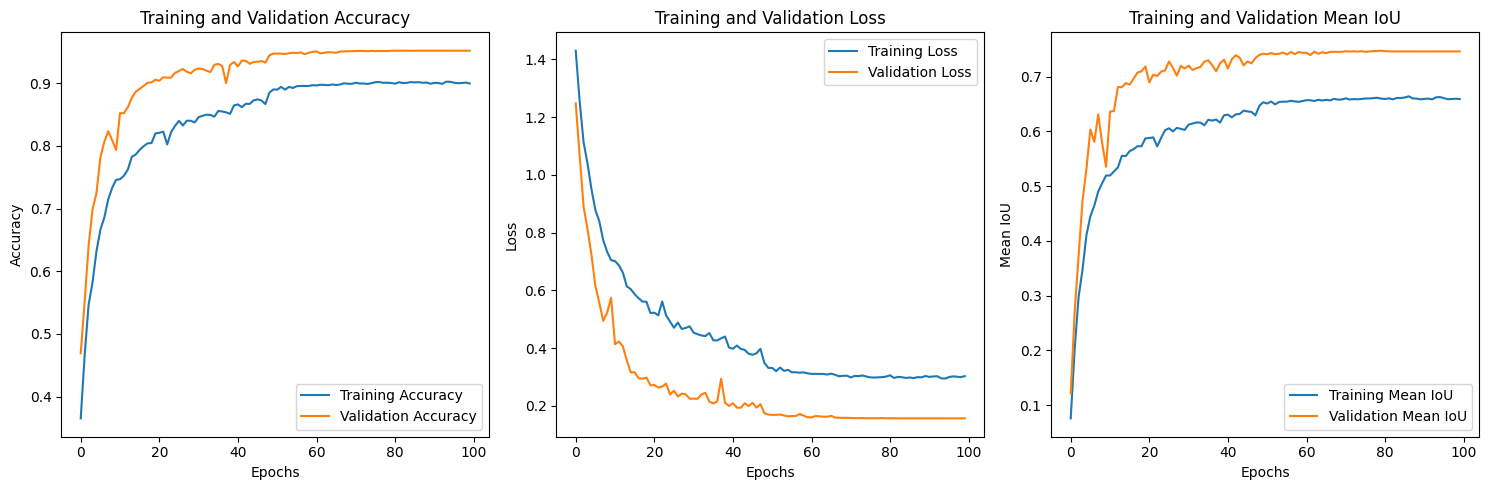

In [97]:
# Plot training & validation accuracy, loss, and IoU
def plot_metrics(history):
    metrics = ['accuracy', 'loss', 'mean_iou']
    titles = ['Accuracy', 'Loss', 'Mean IoU']

    plt.figure(figsize=(15, 5))

    for i, metric in enumerate(metrics):
        plt.subplot(1, 3, i+1)
        plt.plot(history.history[metric], label=f'Training {titles[i]}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {titles[i]}')
        plt.title(f'Training and Validation {titles[i]}')
        plt.xlabel('Epochs')
        plt.ylabel(titles[i])
        plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the metrics
plot_metrics(history)

# 📋 Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


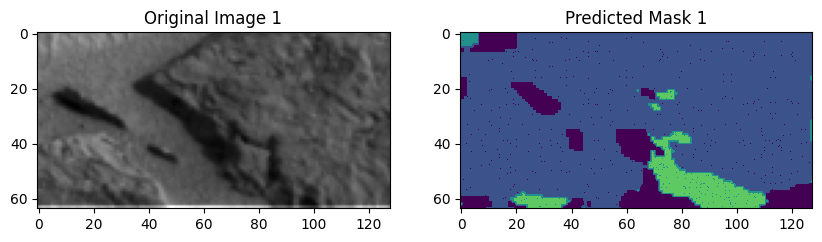

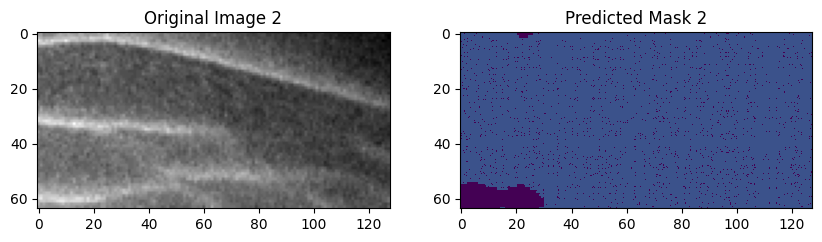

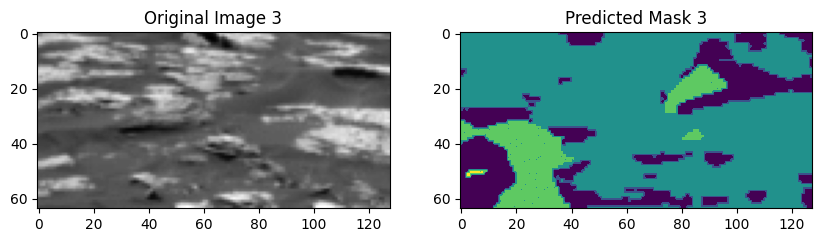

In [98]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming X_test is already loaded and preprocessed (normalized, with added color channel if necessary)
# If not, load and preprocess it as you did for X_train and X_val

# Predict masks for the first 3 images in X_test
predictions = simple_model.predict(X_test[:3])

# Get the class with the highest probability for each pixel
predicted_masks = np.argmax(predictions, axis=-1)

# Display the predictions
for i in range(3):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(X_test[i].squeeze(), cmap='gray')  # Display the original image
    plt.title(f"Original Image {i+1}")

    plt.subplot(1, 2, 2)
    plt.imshow(predicted_masks[i], cmap=cmap, norm=norm)  # Display the predicted mask
    plt.title(f"Predicted Mask {i+1}")

    plt.show()

## 🔬 Inference

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


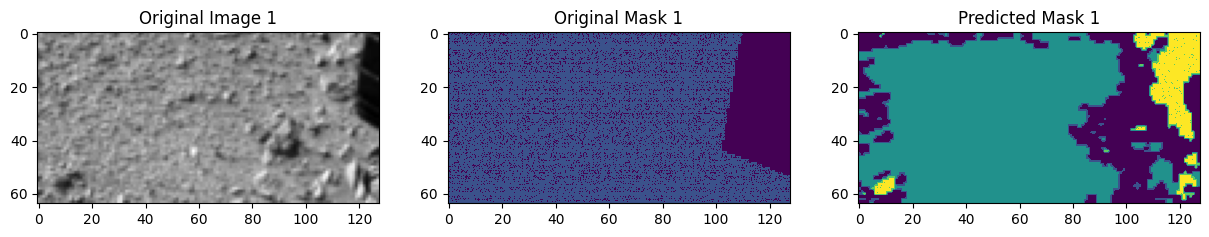

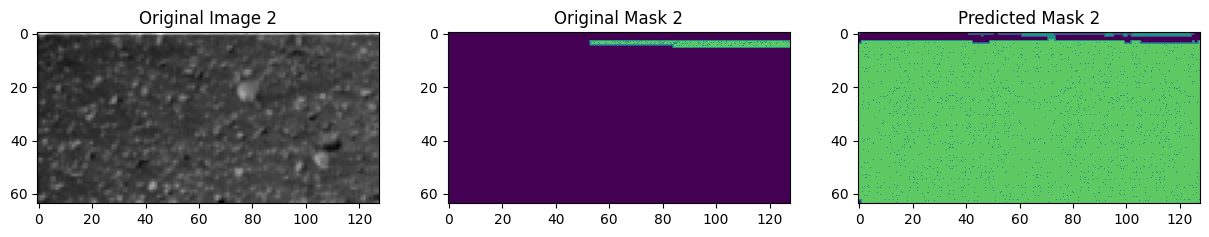

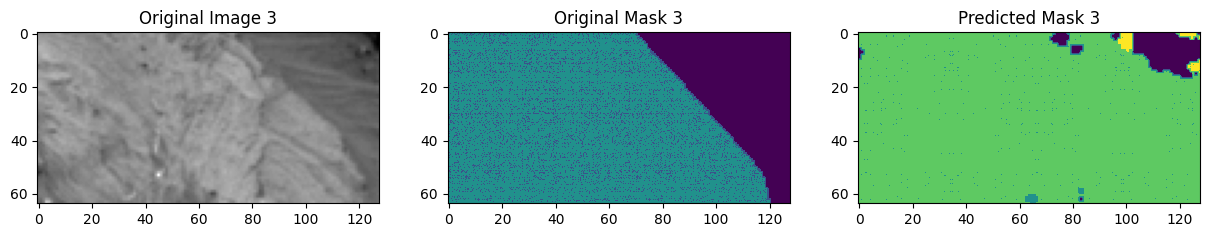

In [99]:
import matplotlib.pyplot as plt

predictions = simple_model.predict(X_train[:3])
predicted_masks = np.argmax(predictions, axis=-1)

# Display the predictions
for i in range(3):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(X_train[i].squeeze(), cmap='gray')  # Display the original image
    plt.title(f"Original Image {i+1}")

    plt.subplot(1, 3, 2)
    plt.imshow(y_train[i], cmap=cmap, norm=norm)  # Display the original mask
    plt.title(f"Original Mask {i+1}")

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_masks[i], cmap=cmap, norm=norm)  # Display the predicted mask
    plt.title(f"Predicted Mask {i+1}")

    plt.show()

In [100]:
# Mean IoU
mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes)
mean_iou.update_state(y_train[:3], predicted_masks)
iou = mean_iou.result().numpy()
print(f"Mean IoU: {iou}")

# Pixel accuracy
pixel_accuracy = np.mean(y_train[:3] == predicted_masks)
print(f"Pixel accuracy: {pixel_accuracy}")

Mean IoU: 0.019611408933997154
Pixel accuracy: 0.0511474609375


In [101]:
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

def evaluate_per_class(y_true, y_pred, num_classes=5):
    """
    Compute precision, recall, F1-score e IoU for each class.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    metrics = {
        "Class": [],
        "Precision": [],
        "Recall": [],
        "F1-Score": [],
        "IoU": []
    }

    for c in range(num_classes):
        class_true = (y_true_flat == c).astype(int)
        class_pred = (y_pred_flat == c).astype(int)

        precision = precision_score(class_true, class_pred, zero_division=0)
        recall = recall_score(class_true, class_pred, zero_division=0)
        f1 = f1_score(class_true, class_pred, zero_division=0)
        iou = jaccard_score(class_true, class_pred, zero_division=0)

        metrics["Class"].append(c)
        metrics["Precision"].append(precision)
        metrics["Recall"].append(recall)
        metrics["F1-Score"].append(f1)
        metrics["IoU"].append(iou)

    return metrics

# Prediction on the validation set
val_predictions = simple_model.predict(X_val, verbose=0)
val_predicted_masks = np.argmax(val_predictions, axis=-1)

# Metrics
metrics = evaluate_per_class(y_val, val_predicted_masks)

# Results
import pandas as pd
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

   Class  Precision    Recall  F1-Score       IoU
0      0   0.371014  0.317706  0.342297  0.206489
1      1   0.560267  0.090376  0.155645  0.084390
2      2   0.423212  0.521584  0.467277  0.304867
3      3   0.365574  0.787827  0.499409  0.332808
4      4   0.003085  0.115016  0.006009  0.003014


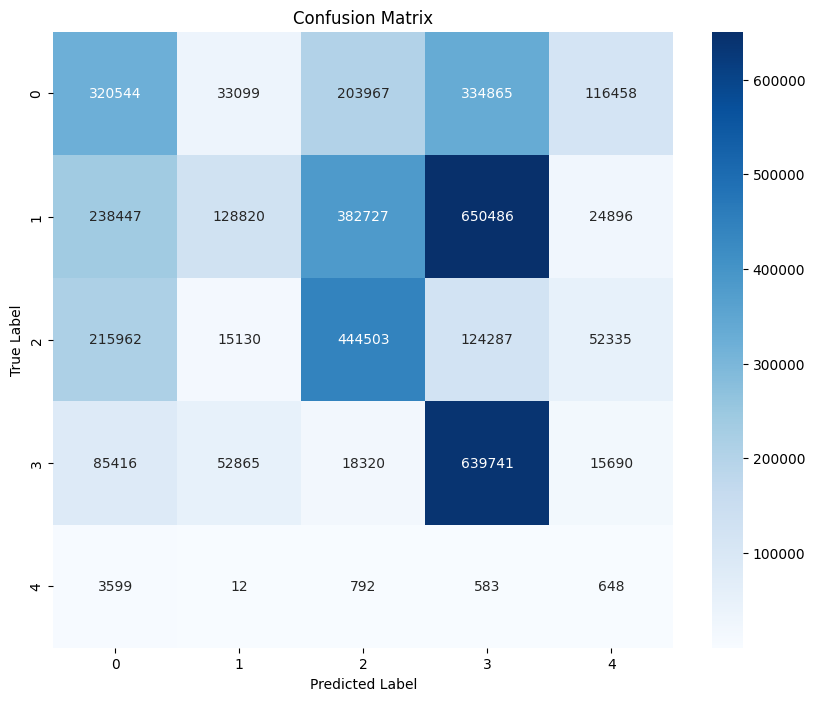

In [102]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, num_classes=5):
    cm = confusion_matrix(y_true.flatten(), y_pred.flatten(), labels=range(num_classes))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Plot matrice di confusione
plot_confusion_matrix(y_val, val_predicted_masks, num_classes=5)

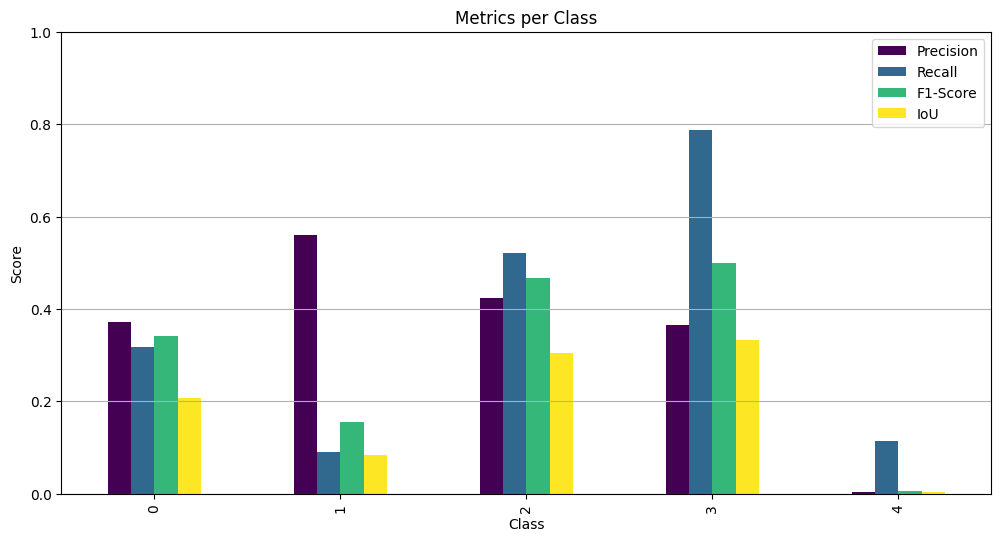

In [103]:
def plot_metrics(metrics_df):
    metrics_df.plot(
        x="Class",
        y=["Precision", "Recall", "F1-Score", "IoU"],
        kind="bar",
        figsize=(12, 6),
        colormap="viridis",
        title="Metrics per Class"
    )
    plt.xlabel("Class")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.grid(axis="y")
    plt.show()

# Plot delle metriche
plot_metrics(metrics_df)
